In [1]:
!nvidia-smi

Tue Jun 23 00:04:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q cython pyyaml==5.1 #Cython
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI' # Coco API
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -q -e detectron2_repo

     |████████████████████████████████| 276kB 2.6MB/s 
Cloning into 'detectron2_repo'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 5583 (delta 2), reused 9 (delta 2), pack-reused 5563
Receiving objects: 100% (5583/5583), 2.58 MiB | 2.38 MiB/s, done.
Resolving deltas: 100% (4020/4020), done.


In [4]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [2]:
from detectron2.data.datasets import register_coco_instances

# Name of the Directory Contatining the data
Folder_name = 'FaceSegment'

# Name of the data we will register with Detectron2
Register_name = 'FS_1'

for folder in ["train", "test"]:
    # Name, Path to JSON, Path to image directory
    register_coco_instances(f"{Register_name}_{folder}",
                            {},
                            f"{Folder_name}/{folder}.json",
                            f"{Folder_name}/{folder}")

# View Images From DataSet
Below we randomly choose 2 images from our training dataset to view what was labeled.

WARNING [06/23 00:04:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/23 00:04:47 d2.data.datasets.coco]: Loaded 39 images in COCO format from FaceSegment/train.json


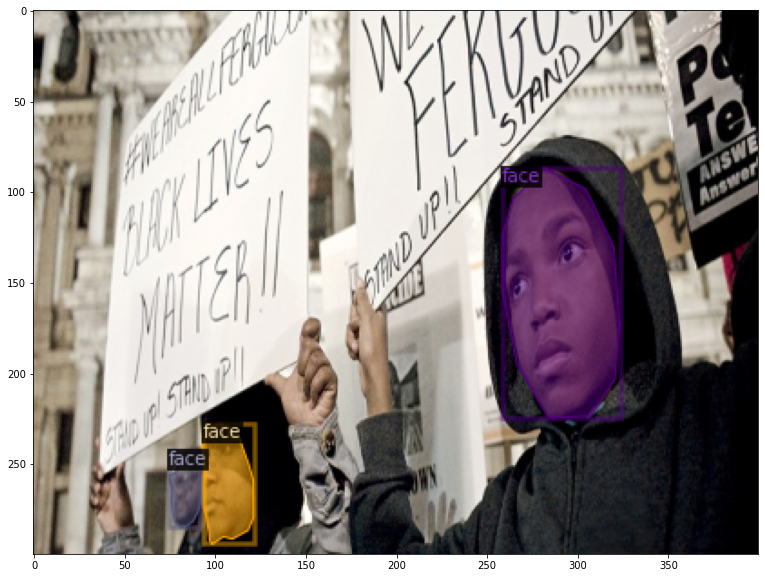

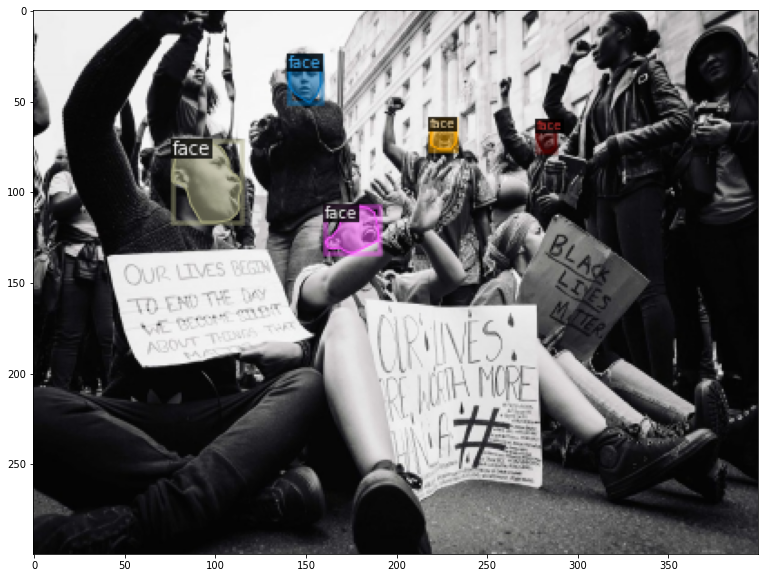

In [5]:
import random
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_dicts = DatasetCatalog.get(f"{Register_name}_train")
face_metadata = MetadataCatalog.get(f"{Register_name}_train")

for d in random.sample(dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=face_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

# Train the model
Here we perform transfer learning and train the model. We will train the model with 2 workers, a learning rate of .00025, and 1000 iterations.



In [6]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (f"{Register_name}_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2 # Can increase when GPU has larger amount of memory
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # Only detecting one class, faces

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/23 00:05:01 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (1,) in the model!


[06/23 00:05:03 d2.engine.train_loop]: Starting training from iteration 0
[06/23 00:05:09 d2.utils.events]:  eta: 0:04:45  iter: 19  total_loss: 1.798  loss_cls: 0.783  loss_box_reg: 0.061  loss_mask: 0.689  loss_rpn_cls: 0.216  loss_rpn_loc: 0.044  time: 0.2908  data_time: 0.0148  lr: 0.000005  max_mem: 2335M
[06/23 00:05:15 d2.utils.events]:  eta: 0:04:43  iter: 39  total_loss: 1.713  loss_cls: 0.717  loss_box_reg: 0.055  loss_mask: 0.687  loss_rpn_cls: 0.189  loss_rpn_loc: 0.056  time: 0.2929  data_time: 0.0057  lr: 0.000010  max_mem: 2335M
[06/23 00:05:21 d2.utils.events]:  eta: 0:04:34  iter: 59  total_loss: 1.544  loss_cls: 0.596  loss_box_reg: 0.071  loss_mask: 0.681  loss_rpn_cls: 0.162  loss_rpn_loc: 0.047  time: 0.2895  data_time: 0.0044  lr: 0.000015  max_mem: 2335M
[06/23 00:05:27 d2.utils.events]:  eta: 0:04:29  iter: 79  total_loss: 1.437  loss_cls: 0.440  loss_box_reg: 0.065  loss_mask: 0.672  loss_rpn_cls: 0.186  loss_rpn_loc: 0.058  time: 0.2908  data_time: 0.0048  lr:

In [8]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = (f"{Register_name}_test", )
predictor = DefaultPredictor(cfg)

In [9]:
print (os.path.join(cfg.OUTPUT_DIR, "model_final.pth"))

./output/model_final.pth


# Perform Image Processing
Here we will
* Use the outputs of the model to segemnt faces in the images
* Create masks using the output to
  1. Get Images of the Faces detected
  2. Create an image from the original image without the detected faces
* Blur the iamge containing the faces
* Combine the blured image and the orignal image


## Note
Amount of blurring can be changed by changing the size of the convolution filter that we input to cv2.blur

WARNING [06/23 00:14:00 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/23 00:14:00 d2.data.datasets.coco]: Loaded 39 images in COCO format from FaceSegment/train.json
Number of faces detected 7


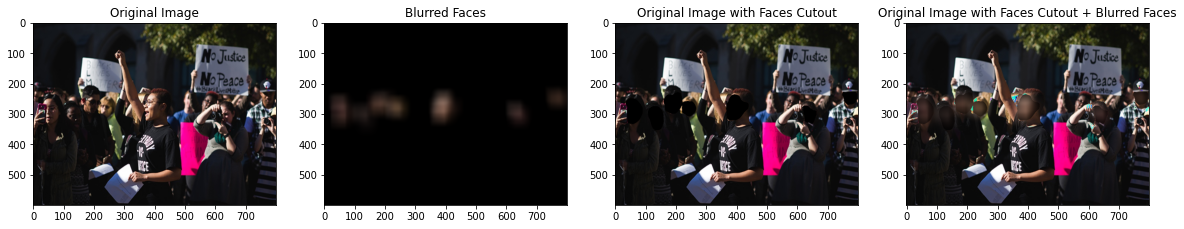

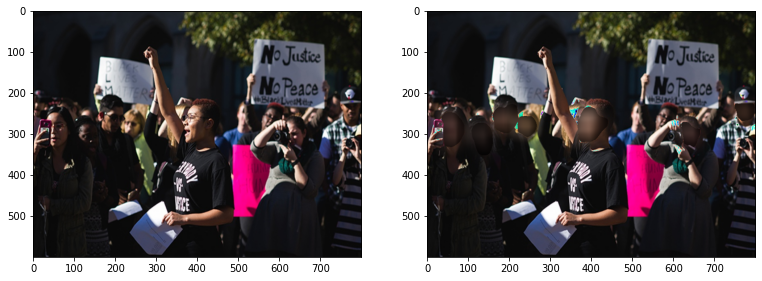

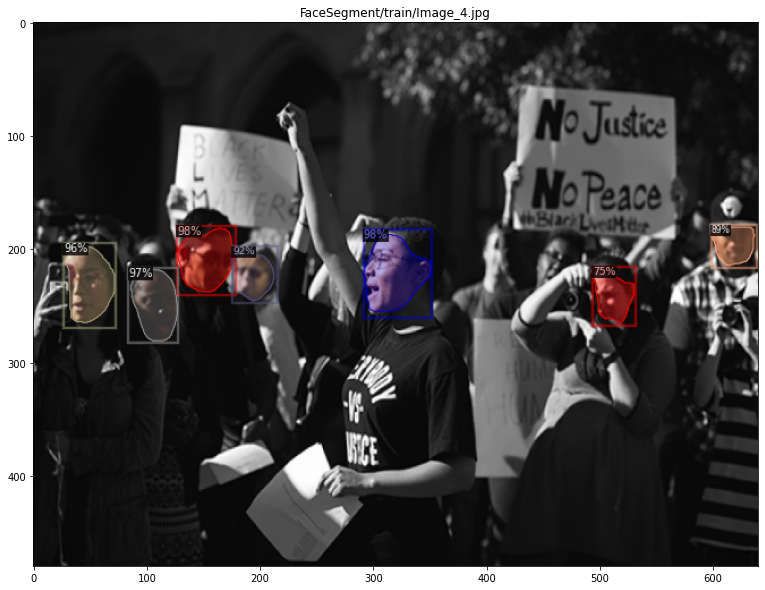

Number of faces detected 8


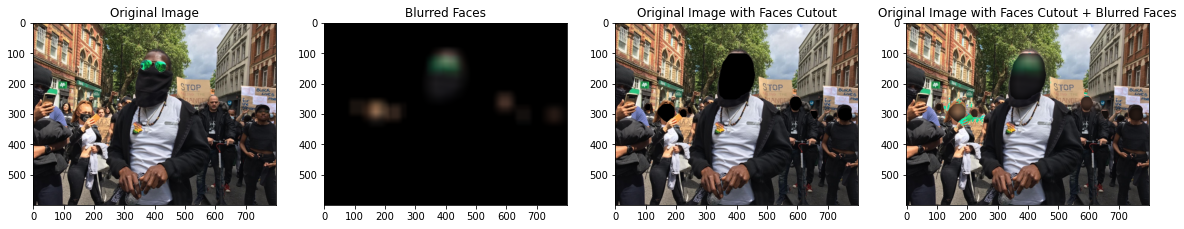

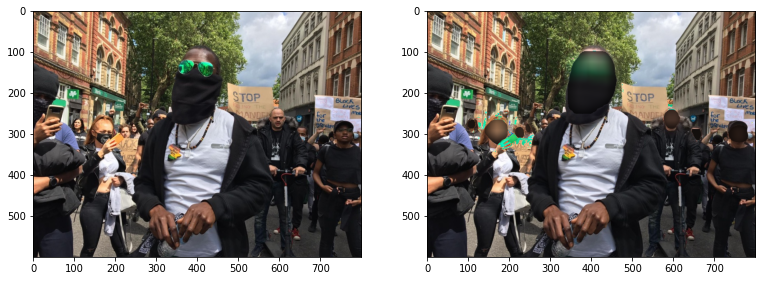

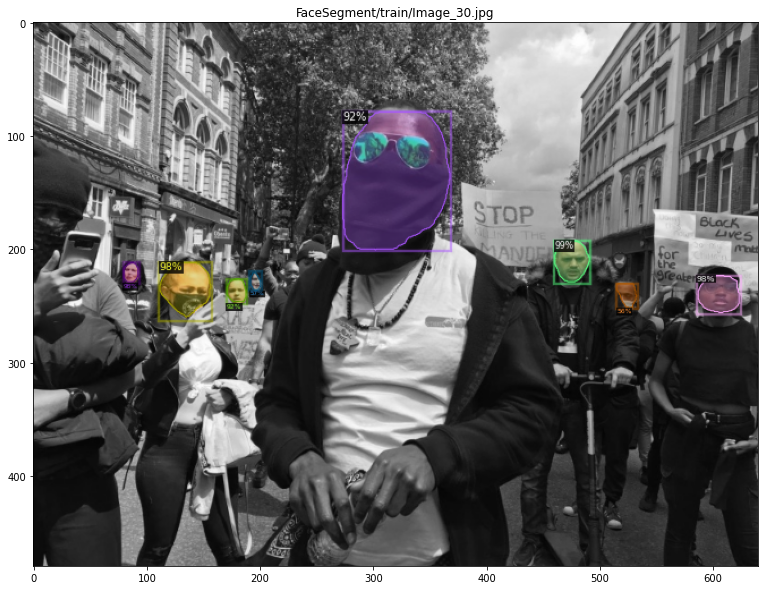

In [12]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get(f"{Register_name}_train")

# Iterate through images in the dataset
for d in random.sample(dataset_dicts, 2):    
    # Load the image
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print ('Number of faces detected', len(outputs['instances'].pred_masks))
    
    # Create image masks
    # Get the shape of an image by taking the shape of the fist prediction mask
    image_shape = np.shape(outputs['instances'].pred_masks.to('cpu').numpy()[0])
    image_all_masks = np.zeros(image_shape)

    # Iterate through each of the faces and combine their positions into one image
    for predmask in outputs['instances'].pred_masks:
      # print ('------------')
      # print (predmask.to('cpu').numpy()*1) # Convert each mask to an numpy array
      # print ('------------')
      # Sum up all the masks together
      image_all_masks = image_all_masks + predmask.to('cpu').numpy()*1
    # Combine all the detected faces, masks, together  
    combined_masks = 1 - (1- image_all_masks)
    combined_masks = np.array(combined_masks, dtype = bool) # Convert mask to bool; instead of 0's and 1's
    

    # Get pixels of original image given combined_mask
    # Create 3D Mask because original image is RGB
    y = np.expand_dims(combined_masks, axis = 2) # Add Extra Dim
    combined_mask_3d = np.concatenate((y, y, y, ), axis = 2) # Stack to make 3d
    masked_im = im*combined_mask_3d
    blur_masked_im = cv2.blur(masked_im, (50,50)) # Blur out the faces

    # Get inverted cutout, meaning get image with the detected faces cutout
    combined_masks_inv = np.invert(combined_masks)
    y_inv = np.expand_dims(combined_masks_inv, axis = 2) # Add Extra Dim
    combined_mask_inv_3d = np.concatenate((y_inv, y_inv, y_inv, ), axis = 2) # Stack to make 3d
    masked_im_inv = im*combined_mask_inv_3d

    """ Displaying the Output"""
    # View the Original Image, blurred faces, original image without faces, and final image
    plt.figure(figsize = (20, 10))
    plt.subplot(141)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")

    plt.subplot(142)
    plt.imshow(cv2.cvtColor(blur_masked_im, cv2.COLOR_BGR2RGB))
    plt.title("Blurred Faces")

    plt.subplot(143)
    plt.imshow(cv2.cvtColor(masked_im_inv, cv2.COLOR_BGR2RGB))
    plt.title("Original Image with Faces Cutout")

    plt.subplot(144)
    plt.imshow(cv2.cvtColor(blur_masked_im+masked_im_inv, cv2.COLOR_BGR2RGB))
    plt.title("Original Image with Faces Cutout + Blurred Faces")

    plt.show()

    " View Before and After "
    plt.figure(figsize = (20, 10))
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

    plt.subplot(132)
    plt.imshow(cv2.cvtColor(blur_masked_im+masked_im_inv, cv2.COLOR_BGR2RGB))

    plt.show()


    " View what the algorithm found along with confidence scores "
    v = Visualizer(im[:, :, ::-1],
                   metadata=face_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode(2)   # remove the colors of unsegmented pixels
    )
    
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    plt.figure(figsize = (20, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.title(d["file_name"])
    plt.show()